<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/demo/notebook/04_tableone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
!pip install tableone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tableone import TableOne
from sklearn.linear_model import LogisticRegression as lr
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
cohort_table = pd.read_csv('table_cohort.csv')

In [ ]:
cohort_table

,stay_id,hadm_id,subject_id,age,Gender,ethnicity,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
0,36014877,27162817,11861017,87,0,WHITE,1,1.595745,0,1,...,17.600000,36.416667,100.000000,247.375000,1.0,1.0,1,0,0,15
1,32272859,25963696,11259141,60,1,WHITE,1,1.633333,0,7,...,17.333333,36.898333,97.259259,120.200000,1.0,1.0,1,0,0,18
2,34023828,21782431,18010960,59,0,UNKNOWN,1,1.589041,0,1,...,15.392857,36.786667,96.629630,98.000000,1.0,1.0,1,0,0,15
3,37798199,29764966,10926537,42,1,BLACK/AFRICAN AMERICAN,1,1.568627,0,7,...,17.240000,37.142857,99.791667,95.000000,1.0,1.0,1,0,0,17
4,32309766,29272306,15703353,59,1,WHITE,1,1.517241,0,6,...,21.740741,37.372000,98.178571,136.800000,1.0,1.0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35295,39955170,24679700,12799579,55,1,WHITE,0,1.464286,1,7,...,24.148148,37.325000,94.115385,148.333333,0.0,1.0,1,0,0,19
35296,39977793,20968809,13886051,66,1,WHITE,0,1.407407,1,3,...,14.400000,36.646364,97.205882,96.333333,0.0,1.0,1,1,1,19
35297,39980385,21253505,11392990,73,0,WHITE,0,1.592593,1,5,...,19.605263,36.835000,93.605263,203.200000,0.0,1.0,1,1,0,6
35298,39985296,29295929,19632565,59,1,WHITE,0,1.782609,1,2,...,25.692308,36.603333,96.296296,173.400000,0.0,1.0,1,1,1,15


In [ ]:
cohort_table.columns

Index(['stay_id', 'hadm_id', 'subject_id', 'age', 'Gender', 'ethnicity',
       'midodrine', 'avg_doses_per_24_hrs', 'MICU', 'adm_weekday', 'weight',
       'sapsii', 'charlson_index', 'CPD_or_COPD_rate', 'Maligancy_rate',
       'mild_liver_rate', 'severe_liver_rate', 'Renal_rate', 'CAD_rate',
       'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium', 'potassium',
       'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate', 'ph', 'po2',
       'pco2', 'bnp', 'troponin', 'creatinine_kinase', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use',
       'ventilation_use', 'vasopressor_use', 'mortality', 'mort_28_day',
       'admit_hour'],
      dtype='object')

## Creating Population Table
Tom J Pollard, Alistair E W Johnson, Jesse D Raffa, Roger G Mark; tableone: An open source Python package for producing summary statistics for research papers, JAMIA Open, https://doi.org/10.1093/jamiaopen/ooy012

In [ ]:
table_columns = ['midodrine', 'age', 'Gender', 'MICU', 'weight',
       'sapsii', 'charlson_index', 'CPD_or_COPD_rate', 'Maligancy_rate',
       'mild_liver_rate', 'severe_liver_rate', 'Renal_rate', 'CAD_rate',
       'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium', 'potassium',
       'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate', 'ph', 'po2',
       'pco2', 'bnp', 'troponin', 'creatinine_kinase', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use', 
       'ventilation_use', 'mort_28_day', 'adm_weekday', 'ethnicity']

table_categorical = ['Gender', 'ethnicity', 'adm_weekday']

table_groupby = 'midodrine'

table_nonnormal = ['age', 'weight', 'sapsii', 'charlson_index', 'bicarbonate', 'bun',
             'creatinine', 'spo2_mean']

In [ ]:
mytable = TableOne(cohort_table, columns=table_columns, categorical=table_categorical, groupby=table_groupby, nonnormal=table_nonnormal, pval=True)

In [ ]:
print(mytable.tabulate(tablefmt = "fancy_grid"))

╒════════════════════════════════╤═══════════════════════════════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                                │                               │ Missing   │ Overall          │ 0                │ 1                │ P-Value   │
╞════════════════════════════════╪═══════════════════════════════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                              │                               │           │ 35300            │ 34490            │ 810              │           │
├────────────────────────────────┼───────────────────────────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ age, median [Q1,Q3]            │                               │ 0         │ 64.0 [51.0,77.0] │ 64.0 [51.0,77.0] │ 63.0 [53.0,73.0] │ 0.210     │
├────────────────────────────────┼───────────────────────────────┼───────────┼──────────────────┼───────────────

In [ ]:
features_complete = pd.read_csv('features_complete.csv')
features_complete = features_complete.iloc[:,1:] #dropping 0th index column (redundant)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f496ccc1190>]],
      dtype=object)

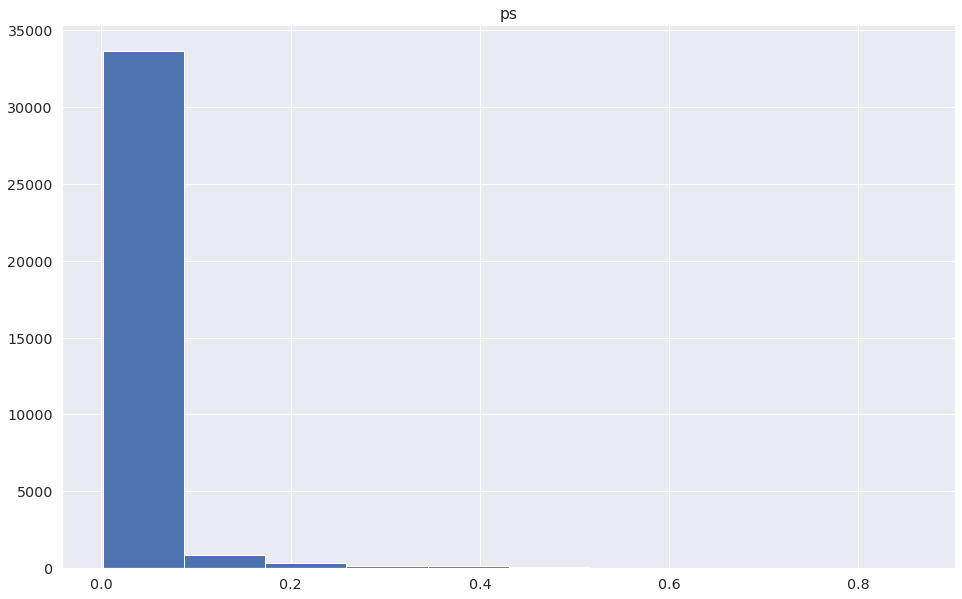

In [ ]:
features_complete.hist("ps")

In [ ]:
weighted_cohort_id = pd.read_csv('weighted_cohort_id.csv')

In [ ]:
weighted_cohort_id = weighted_cohort_id['stay_id'].tolist()

In [ ]:
weighted_cohort_id = weighted_cohort_id.sort()

In [ ]:
weighted_cohort = cohort_table[cohort_table.index.isin(weighted_cohort_id)]

In [ ]:
weighted_cohort

,stay_id,hadm_id,subject_id,age,Gender,ethnicity,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
1,32272859,25963696,11259141,60,1,WHITE,1,1.633333,0.0,7.0,...,17.333333,36.898333,97.259259,120.200000,1.0,1.0,1.0,0.0,0.0,18.0
2,34023828,21782431,18010960,59,0,UNKNOWN,1,1.589041,0.0,1.0,...,15.392857,36.786667,96.629630,98.000000,1.0,1.0,1.0,0.0,0.0,15.0
3,37798199,29764966,10926537,42,1,BLACK/AFRICAN AMERICAN,1,1.568627,0.0,7.0,...,17.240000,37.142857,99.791667,95.000000,1.0,1.0,1.0,0.0,0.0,17.0
4,32309766,29272306,15703353,59,1,WHITE,1,1.517241,0.0,6.0,...,21.740741,37.372000,98.178571,136.800000,1.0,1.0,1.0,0.0,0.0,3.0
5,32470068,29923619,12682108,32,1,WHITE,1,1.666667,0.0,3.0,...,16.187500,36.743750,97.437500,137.500000,0.0,1.0,1.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21146,37931684,23401888,16917096,76,0,WHITE,0,1.793103,0.0,1.0,...,14.548387,36.805000,98.225806,108.500000,0.0,1.0,1.0,1.0,0.0,21.0
21302,39661672,29736871,11343484,71,0,WHITE,0,1.515464,0.0,4.0,...,17.750000,36.823333,95.071429,142.500000,1.0,1.0,1.0,0.0,0.0,16.0
21328,39943884,24720945,16533974,63,0,UNKNOWN,0,1.500000,0.0,6.0,...,16.000000,35.560000,98.666667,NaN,1.0,NaN,1.0,1.0,0.0,22.0
21418,30827926,24899138,10570405,32,1,WHITE,0,1.375000,0.0,7.0,...,18.653846,36.798000,96.884615,94.750000,0.0,NaN,1.0,0.0,0.0,13.0


In [ ]:
mytable_weighted = TableOne(weighted_cohort, columns=table_columns, categorical=table_categorical, groupby=table_groupby, nonnormal=table_nonnormal, pval=True)

In [ ]:
print(mytable_weighted.tabulate(tablefmt = "fancy_grid"))

╒════════════════════════════════╤═══════════════════════════════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                                │                               │ Missing   │ Overall          │ 0                │ 1                │ P-Value   │
╞════════════════════════════════╪═══════════════════════════════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                              │                               │           │ 881              │ 368              │ 513              │           │
├────────────────────────────────┼───────────────────────────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ age, median [Q1,Q3]            │                               │ 0         │ 63.0 [51.0,76.0] │ 63.0 [49.8,78.0] │ 64.0 [53.0,74.0] │ 0.683     │
├────────────────────────────────┼───────────────────────────────┼───────────┼──────────────────┼───────────────